# Open The Cameras

## Cameras On The Base

In [1]:
from FlexivPy.vision import RealSenseCamera

In [3]:
# Camera to the left of the robot
camera1 = RealSenseCamera(VGA=False, camera_serial_no='234222302193')

Enabling streams for camera:  234222302193


In [5]:
# Camera to the right of the robot
camera2 = RealSenseCamera(VGA=False, camera_serial_no='231622302407')

Enabling streams for camera:  231622302407


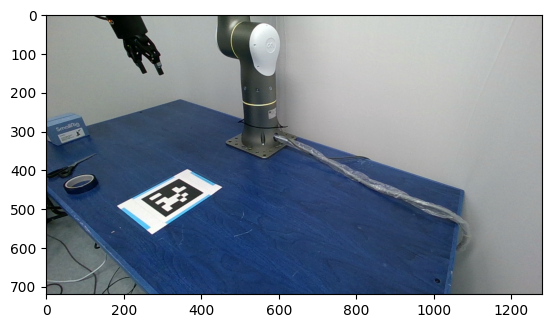

In [6]:
import matplotlib.pyplot as plt

plt.imshow(camera1.color_frame)

In [7]:
import time
left_camera_imgs = []
right_camera_imgs = []
for i in range(120):
    left_img = camera1.color_frame.copy()
    right_img = camera2.color_frame.copy()
    left_camera_imgs.append(left_img)
    right_camera_imgs.append(right_img)
    time.sleep(0.5)

In [8]:
left_cam_ints = camera1.getIntrinsics()
right_cam_ints = camera2.getIntrinsics()

In [10]:
import pickle 
with open('cam_on_base_calib.pkl', 'wb') as f:
    pickle.dump(
        {
            'left_imgs':left_camera_imgs,
            'right_imgs':right_camera_imgs,
            'left_params':left_cam_ints,
            'right_params':right_cam_ints
        },
        f
    )

# Camera on EF

In [1]:
import cv2
def camera_callback(color_frame, depth_frame, ir1_frame, ir2_frame):
    cv2.imshow('frame', color_frame)
    cv2.waitKey(1)

In [2]:
from FlexivPy.vision import RealSenseCamera
camera = RealSenseCamera(VGA=False, callback_fn=camera_callback)
camera_ints = camera.getIntrinsics()

Enabling streams for camera:  141222073965


: 

In [4]:
from FlexivPy.joy import XBoxController
joy = XBoxController(0)

Put your stick at reset and do not touch it while calibrating


In [5]:
joy.getStates()

{'left_joy': array([ 0., -0.]),
 'right_joy': array([ 0., -0.]),
 'left_trigger': 0.0004999999999999449,
 'right_trigger': 0.0004999999999999449,
 'A': 0,
 'B': 0,
 'X': 0,
 'Y': 0,
 'left_bumper': 0,
 'right_bumper': 0,
 'options_left': 0,
 'options_right': 0,
 'left_joy_btn': 0,
 'right_joy_btn': 0}

In [6]:
import pinocchio as pin
import numpy as np
from FlexivPy.robot.model.pinocchio import FlexivModel
from FlexivPy.robot.interface import FlexivDDSClient
model = FlexivModel()
robot = FlexivDDSClient()

waiting to receive the first message from the robot...
Robot is ready!


In [7]:
from FlexivPy.controllers.runners import NonBlockingRunner
from FlexivPy.controllers.taskspace import DiffIKController
task_controller = DiffIKController(model, dt=0.01, dq_max=1., control_mode='velocity')

In [9]:
runner = NonBlockingRunner(robot, task_controller, timeout=300.)

max time reached


In [10]:
import time
import numpy as np
import datetime

images = []
robot_poses = []
time.sleep(0.2)
state = robot.get_robot_state()

if state is not None:
    print('starting the controller')
    info = model.getInfo(np.array(state.q), np.array(state.dq))
    T0 = info['poses']['link7']
    # Initialize the desired pose
    x0, y0, z0 = 0.0, 0.0, 0.0 
    R0 = np.eye(3)
    start_time = time.time()
    while time.time()-start_time < 100:
        joy_state = joy.getStates()
        left_joy = joy_state['left_joy']
        right_joy = joy_state['right_joy']

        if joy_state['right_bumper']==0:
            y0 = y0 + right_joy[0]*0.2/100
            x0 = x0 + right_joy[1]*0.2/100
            z0 = z0 - left_joy[1]*0.2/100
        else:
            cmd = np.array([right_joy[0],right_joy[1],left_joy[0]])
            omega_hat = np.array([[ 0,       -cmd[2],  cmd[1]],
                                [ cmd[2],   0,      -cmd[0]],
                                [-cmd[1],   cmd[0],      0]])
            R0 = R0@(np.eye(3)+omega_hat/100)

        time.sleep(0.01)
        T_cmd= T0@np.vstack([np.hstack([R0, np.array([x0,y0,z0]).reshape(3,1)]), np.array([0,0,0,1])])
        task_controller.T_cmd = T_cmd
        state = robot.get_robot_state()
        info = model.getInfo(np.array(state.q), np.array(state.dq))
        T0 = info['poses']['link7']
        if joy_state['A']:
            robot_poses.append(T0.copy())
            images.append(camera.color_frame.copy())
            print('took a pictures')

    print('Demo ended.')
else:
    print('State is None. check the connection')

starting the controller


KeyboardInterrupt: 